# Import Important Packages

In [1]:
import tensorflow as tf
import numpy as np
from glob import glob
import os, random
import matplotlib.pyplot as plt

print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.10.0


# Check GPU Available

In [2]:
print("GPU Available: ", tf.config.list_physical_devices("GPU"))
!nvidia-smi -L

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU 0: NVIDIA GeForce RTX 3050 Laptop GPU (UUID: GPU-509cf0ce-8a5d-aa4a-fa20-6093938c3e7e)


# Exploratory Data Analyst

Dataset ini diekspor melalui [universe.roboflow.com](https://universe.roboflow.com/palm-fruit-classification/palm-fruit-ripeness-classificationcnn) pada 23 September 2023 pukul 04.36 GMT

Kumpulan data mencakup 3024 gambar.
Buah sawit dalam format klip.

Pra-pemrosesan berikut diterapkan pada setiap gambar:
* Orientasi otomatis data piksel (dengan stripping orientasi EXIF)
* Ubah ukuran menjadi 299x299 (Peregangan)

In [5]:
train_path = "G:/My Drive/Dataset/Chili Leaf Disease/train"
val_path = "G:/My Drive/Dataset/Chili Leaf Disease/val"
images_path = glob(train_path + "/*/*.jp*g")
classname = os.listdir(train_path)

## View Image Randomly

Image Shape:  (217, 233, 3)
G:/My Drive/Dataset/Chili Leaf Disease/train\leaf spot\leaf spot49.jpg


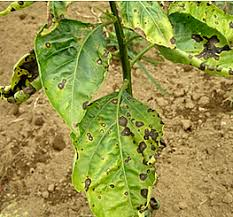

In [6]:
from IPython.display import Image
import matplotlib.image as mpimg

random_img = random.choice(images_path)
print("Image Shape: ", mpimg.imread(random_img).shape)
print(random_img)
Image(random_img)

# Get Dataset From Directory

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1/255.,
                            validation_split=0.2)

train_data = datagen.flow_from_directory(train_path,
                                        target_size = (224, 224),
                                        subset = "training",
                                        shuffle = True,
                                        class_mode = 'categorical')

val_data = datagen.flow_from_directory(train_path,
                                      target_size = (224, 224),
                                      subset = 'validation',
                                      shuffle = True,
                                      class_mode = 'categorical')

Found 320 images belonging to 5 classes.
Found 80 images belonging to 5 classes.


In [8]:
from tensorflow.keras.utils import image_dataset_from_directory

train_data = image_dataset_from_directory(train_path,
                                          image_size=(224, 224),
                                          label_mode = "categorical",
                                          seed = 42,
                                          shuffle=True)
val_data = image_dataset_from_directory(val_path,
                                        image_size=(224, 224),
                                        label_mode = "categorical",
                                        seed = 42,
                                        shuffle=True)

Found 400 files belonging to 5 classes.
Found 100 files belonging to 5 classes.


In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
import datetime

logdir = "../Logs/chili/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

early_stopping = EarlyStopping(monitor = "val_accuracy",
                               patience = 10,
                               restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                              mode = 'max',
                              factor = 0.2,
                              patience = 2,
                              min_lr=1e-5)

tensorboard = TensorBoard(logdir)

# Creating a MobileNet Architecture Model

In [13]:
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras import Model
checkpoint_path = "../Checkpoint/chili/chili-mobilenetv3small-" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + ".ckpt"

base_model = MobileNetV3Small(minimalistic = True,
                              include_top = False,
                              weights = 'imagenet')
mobilenet_preprocessor = preprocess_input
for layer in base_model.layers:
  layer.trainable = True

input = Input(shape = (224, 224, 3))
prep_input = mobilenet_preprocessor(input)
x = base_model(prep_input)
x = Flatten()(x)
output = Dense(5, activation = "softmax")(x)

model = Model(inputs = input, outputs=output)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, None, None, 576)  441000    
 l)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 28224)             0         
                                                                 
 dense_1 (Dense)             (None, 5)                 141125    
                                                                 
Total params: 582,125
Trainable params: 570,013
Non-trainable params: 12,112
_________________________________________________________________


# Compile the Model

In [15]:
model.compile(loss ="categorical_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

In [16]:
history = model.fit(train_data,
                    validation_data = val_data,
                    epochs = 100,
                    steps_per_epoch = len(train_data),
                    validation_steps = len(val_data),
                    callbacks = [early_stopping, reduce_lr, tensorboard])

model.save_weights(checkpoint_path)

Epoch 1/100
13/13 [==============================] - 52s 1s/step - loss: 2.8967 - accuracy: 0.4325 - val_loss: 2.1751 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/100
13/13 [==============================] - 2s 93ms/step - loss: 0.4435 - accuracy: 0.9275 - val_loss: 2.5826 - val_accuracy: 0.6300 - lr: 0.0010
Epoch 3/100
13/13 [==============================] - 2s 98ms/step - loss: 0.1238 - accuracy: 0.9700 - val_loss: 2.2317 - val_accuracy: 0.6600 - lr: 0.0010
Epoch 4/100
13/13 [==============================] - 3s 111ms/step - loss: 0.1226 - accuracy: 0.9700 - val_loss: 2.2581 - val_accuracy: 0.6400 - lr: 0.0010
Epoch 5/100
13/13 [==============================] - 3s 107ms/step - loss: 0.1220 - accuracy: 0.9775 - val_loss: 2.1749 - val_accuracy: 0.6500 - lr: 0.0010
Epoch 6/100
13/13 [==============================] - 2s 99ms/step - loss: 0.0903 - accuracy: 0.9775 - val_loss: 2.1536 - val_accuracy: 0.6400 - lr: 2.0000e-04
Epoch 7/100
13/13 [==============================] - 2s 106ms/ste

In [11]:
model.evaluate(val_data)

84/84 [==============================] - 12s 127ms/step - loss: 0.0840 - accuracy: 0.9865


[0.08403051644563675, 0.9865471124649048]

# Load Checkpoint

In [10]:
model.load_weights("C:/Users/salma/pyworkspace/Checkpoint/corn/corn-mobilenetv3small-20231017-021516.ckpt")
model.evaluate(val_data)

84/84 [==============================] - 18s 115ms/step - loss: 0.0727 - accuracy: 0.9832


[0.07272030413150787, 0.9831838607788086]

# Evaluate

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()
	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)
	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')
	else:
		print('Confusion Matrix, Without Normalization')
	print(cm)
	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

In [14]:
y_pred = np.array([])
y_val =  np.array([])
for x, y in val_data:
  y_pred = np.concatenate([y_pred, np.argmax(model.predict(x), axis = -1)])
  y_val = np.concatenate([y_val, np.argmax(y, axis=-1)])

1/1 [==============================] - 1s 1s/step


## Confusion Matrix

Confusion Matrix, Without Normalization
[[487  14   2   0]
 [  9 688   3   1]
 [  0   7 739   0]
 [  0   0   0 726]]


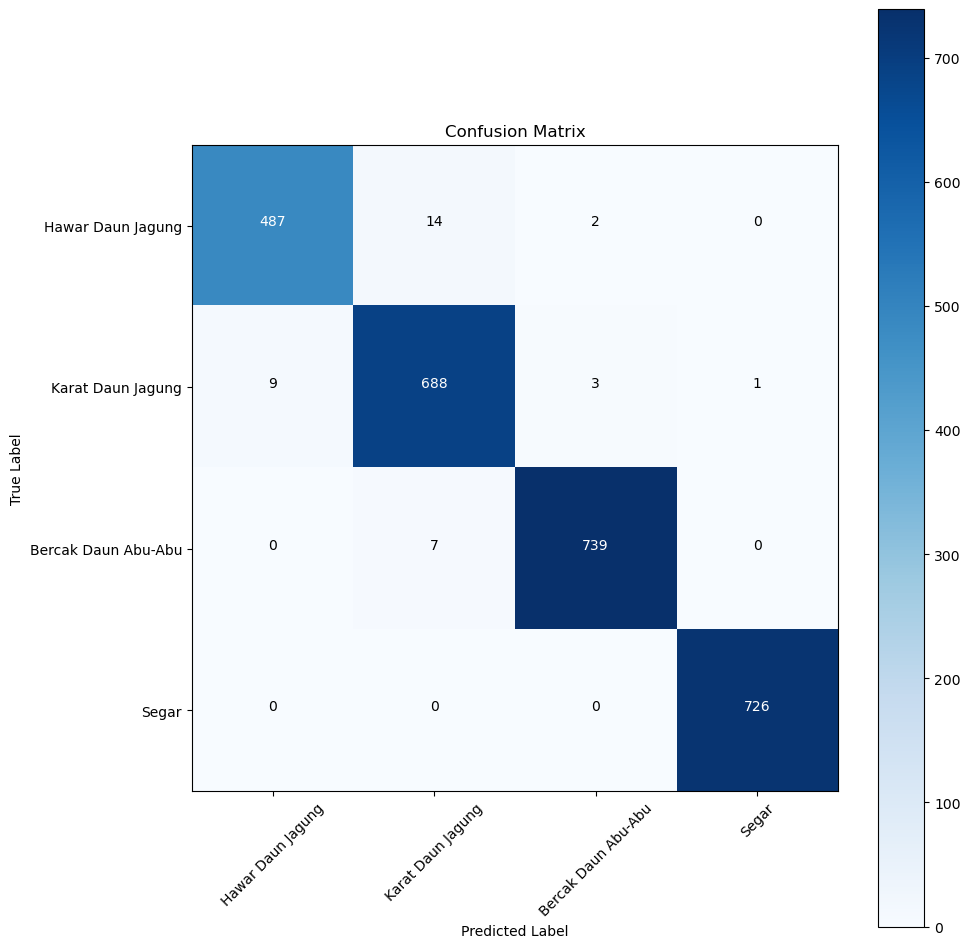

In [15]:
cm = confusion_matrix(y_val, y_pred)
plot_confusion_matrix(cm = cm, classes = classname)

## Classification Report

In [16]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97       503
         1.0       0.97      0.98      0.98       701
         2.0       0.99      0.99      0.99       746
         3.0       1.00      1.00      1.00       726

    accuracy                           0.99      2676
   macro avg       0.99      0.99      0.99      2676
weighted avg       0.99      0.99      0.99      2676



1/1 [==============================] - 0s 18ms/step


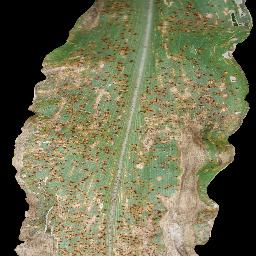

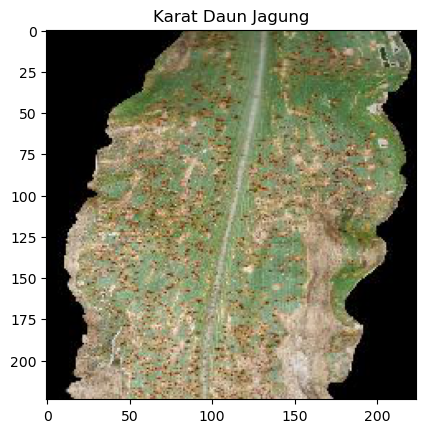

In [71]:
from tensorflow.keras.preprocessing import image

random_img = random.choice(val_data.file_paths)
images = image.load_img(random_img, target_size=(224, 224))
x = image.img_to_array(images)
x = np.expand_dims(x, axis = 0)
img = np.vstack([x])
classes = model.predict(img)
implot = plt.imshow(images)
classname.sort()
plt.title(classname[np.argmax(classes)]);
Image(random_img)

In [11]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("../TFlite/corn/penyakit_functional_architecture.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\salma\AppData\Local\Temp\tmp3dm9_6i3\assets


INFO:tensorflow:Assets written to: C:\Users\salma\AppData\Local\Temp\tmp3dm9_6i3\assets


2168964

In [39]:
classname

['Hawar Daun Jagung', 'Karat Daun Jagung', 'Bercak Daun Abu-Abu', 'Segar']